In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlopen
import json
import os
import re
from json import loads
import plotly.express as px

In [3]:
sfa_path = 'sfa/sfa2223.csv'
df = pd.read_csv(sfa_path)
print(df.columns)

Index(['UNITID', 'XSCUGRAD', 'SCUGRAD', 'XSCUGDGSK', 'SCUGDGSK', 'XSCUGNDGS',
       'SCUGNDGS', 'XSCUGFFN', 'SCUGFFN', 'XSCUGFFP',
       ...
       'XNPT410', 'NPT410', 'XNPT420', 'NPT420', 'XNPT430', 'NPT430',
       'XNPT440', 'NPT440', 'XNPT450', 'NPT450    '],
      dtype='object', length=691)


In [8]:
# Load the SFA data
sfa_path = 'sfa/sfa2223.csv'
df = pd.read_csv(sfa_path)

# Load the variable dictionary
dict_path = 'sfa/sfa_dict.xlsx'
varlist = pd.read_excel(dict_path, sheet_name='varlist')

def shorten_var_title(title):
    # Lowercase, replace non-alphanumeric with space, then join with underscores
    title = title.lower()
    title = re.sub(r'[^a-z0-9]+', ' ', title)
    title = '_'.join(title.split())
    return title

# Create mapping: code -> shortened name
short_names = {row['varname']: shorten_var_title(row['varTitle']) for _, row in varlist.iterrows()}

# Only rename columns that exist in the dataframe
rename_dict = {k: v for k, v in short_names.items() if k in df.columns}

# Rename the columns
df_new = df.rename(columns=rename_dict)

# Add year column
df_new['year'] = '2022–23'

# Add university_name column using get_school_name(unitid)
df_new['university_name'] = df_new['unique_identification_number_of_the_institution'].apply(get_school_name)

# Save to a new CSV
df_new.to_csv('sfa/sfa2223_processed.csv', index=False)

# Show the new columns
print(df_new.columns)

Index(['unique_identification_number_of_the_institution', 'XSCUGRAD',
       'total_number_of_undergraduates_financial_aid_cohort', 'XSCUGDGSK',
       'total_number_of_degree_certificate_seeking_undergraduate_students',
       'XSCUGNDGS',
       'total_number_of_non_degee_non_certificate_seeking_undergraduate_students',
       'XSCUGFFN',
       'total_number_of_full_time_first_time_degree_certificate_seeking_undergraduates_financial_aid_cohort',
       'XSCUGFFP',
       ...
       'XNPT420',
       'average_net_price_income_30_001_48_000_students_awarded_title_iv_federal_financial_aid_2020_21',
       'XNPT430',
       'average_net_price_income_48_001_75_000_students_awarded_title_iv_federal_financial_aid_2020_21',
       'XNPT440',
       'average_net_price_income_75_001_110_000_students_awarded_title_iv_federal_financial_aid_2020_21',
       'XNPT450', 'NPT450    ', 'year', 'university_name'],
      dtype='object', length=693)


# Helper

In [6]:
school_df = pd.read_csv("schoolname_UNITID.csv")

def search_school(school_name):
    # Case-insensitive search for school name
    result = school_df[school_df["inst_name"].str.contains(school_name, case=False, na=False)]
    if result.empty:
        print(f"No matches found for '{school_name}'.")
    return result

def get_school_name(unitid):
    # Fetch school directory data
    url = f"https://educationdata.urban.org/api/v1/college-university/ipeds/directory/2020/?unitid={unitid}"
    response = urlopen(url)
    data = loads(response.read())
    
    results = data.get("results", [])
    if results:
        school_name = results[0].get("inst_name", "Unknown")
        return school_name
    else:
        return f"No school found for unitid {unitid}"

def search_school_by_state(state_abbr):
    """Search for schools in a given state (by abbreviation) and return a DataFrame with unitid and school name.
    """
    url = "https://educationdata.urban.org/api/v1/college-university/ipeds/directory/2020/"
    
    try:
        response = urlopen(url)
        data = loads(response.read())
        results = data.get("results", [])
        
        if not results:
            print(f"No schools found.")
            return pd.DataFrame()
        
        # Filter results manually based on state_abbr
        filtered_results = [
            {"unitid": result.get("unitid"), "school_name": result.get("inst_name", "Unknown")}
            for result in results if result.get("state_abbr") == state_abbr.upper()
        ]
        
        if not filtered_results:
            print(f"No schools found in {state_abbr}.")
            return pd.DataFrame()
        
        return pd.DataFrame(filtered_results)
    
    except Exception as e:
        print(f"Error fetching data: {e}")
        return pd.DataFrame()
        

Get a UNITIDs of New Jersey schools

In [7]:
NJ_schools = search_school_by_state("nj")

if not NJ_schools.empty:
    # Extract the list of unitid values
    NJ_unitid_list = NJ_schools["unitid"].tolist()
    print("List of UNITIDs for schools in New Jersey:", NJ_unitid_list)

    # Fetch and print school names for each unitid
    for unitid in NJ_unitid_list:
        school_name = get_school_name(unitid)
        print(f"UNITID: {unitid}, School Name: {school_name}")
else:
    print("No schools found in New Jersey.")

List of UNITIDs for schools in New Jersey: [183488, 183600, 183655, 183725, 183743, 183789, 183804, 183822, 183859, 183877, 183910, 183938, 183974, 183983, 184047, 184056, 184092, 184180, 184205, 184278, 184348, 184427, 184481, 184506, 184603, 184612, 184694, 184746, 184773, 184782, 184791, 184816, 184870, 184959, 184968, 184995, 185129, 185174, 185262, 185332, 185396, 185466, 185509, 185536, 185572, 185590, 185679, 185721, 185758, 185767, 185828, 185873, 185970, 186016, 186034, 186052, 186122, 186131, 186186, 186201, 186283, 186371, 186380, 186399, 186405, 186423, 186432, 186469, 186584, 186593, 186618, 186645, 186867, 186876, 186900, 187000, 187046, 187134, 187198, 187444, 194718, 245625, 247603, 249140, 363077, 365763, 368230, 374574, 374592, 383279, 384421, 407391, 407407, 407425, 414063, 417831, 420130, 420343, 421878, 430218, 430403, 431716, 436003, 437723, 440794, 441548, 442073, 443216, 443225, 445300, 446224, 446303, 448354, 448983, 449658, 451370, 451398, 453215, 455187, 4551

# 1. Distribution

In [42]:
csv_path = "sfa/sfa2223.csv"
df = pd.read_csv(csv_path)

# Select and rename the relevant columns
selected_columns = {
    'UNITID': 'unit_id',
    'UAGRNTP': 'percent_any_grant_aid',
    'UFLOANP': 'percent_federal_loans',
    'UPGRNTP': 'percent_pell_grants',
    'UAGRNTT': 'total_grants',
    'UPGRNTT': 'total_pell',
    'UFLOANT': 'total_loans'
}

# Filter and rename
df_selected = df[list(selected_columns.keys())].rename(columns=selected_columns)
# Filter df_selected to only include rows where unit_id is in the NJ_unitid_list
df_selected = df_selected[df_selected['unit_id'].isin(NJ_unitid_list)]

# Display the resulting DataFrame
df_selected.head()

,unit_id,percent_any_grant_aid,percent_federal_loans,percent_pell_grants,total_grants,total_pell,total_loans
1751,183488,100,58,76,5578368,1978724,2068114
1752,183600,61,0,0,119110,0,0
1753,183655,76,7,50,14474485,8702397,1726821
1754,183725,73,71,73,2242447,2120128,2787493
1755,183743,90,17,34,34026957,16724914,10674069


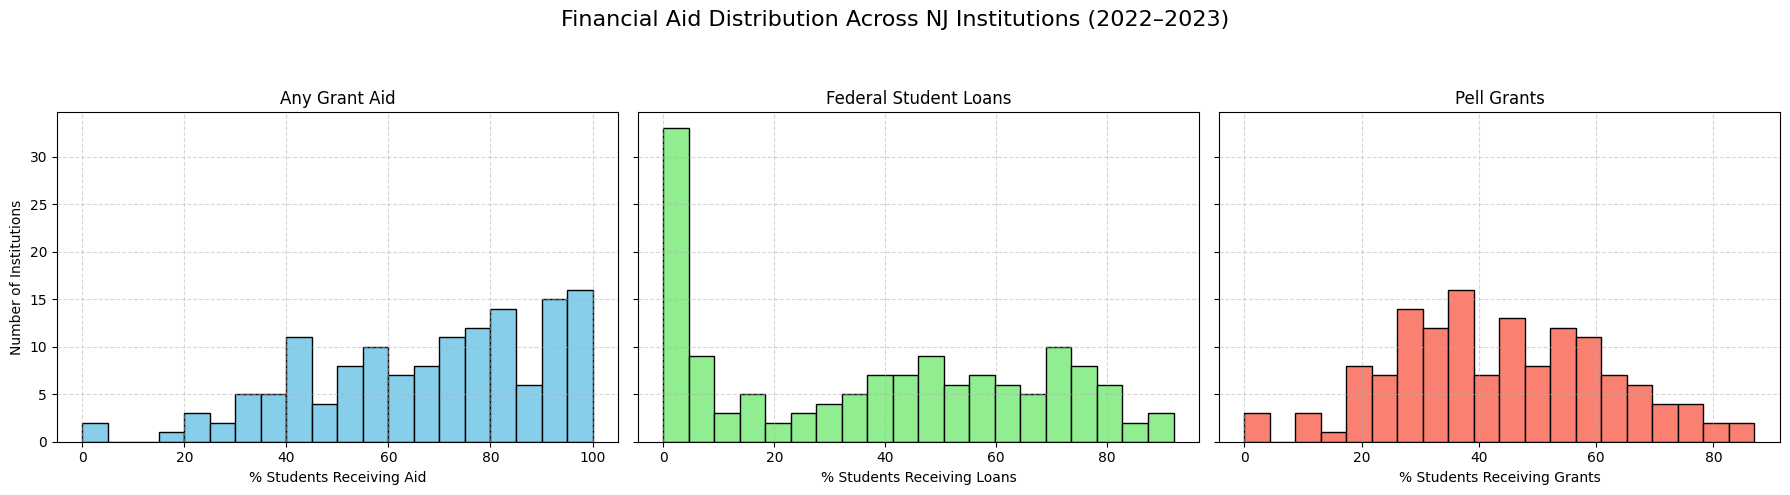

In [51]:
# Set up multi-panel plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
fig.suptitle('Financial Aid Distribution Across NJ Institutions (2022–2023)', fontsize=16)

# Plot histogram for each type of aid
df_selected['percent_any_grant_aid'].plot.hist(ax=axes[0], bins=20, color='skyblue', edgecolor='black')
axes[0].set_title('Any Grant Aid')
axes[0].set_xlabel('% Students Receiving Aid')

df_selected['percent_federal_loans'].plot.hist(ax=axes[1], bins=20, color='lightgreen', edgecolor='black')
axes[1].set_title('Federal Student Loans')
axes[1].set_xlabel('% Students Receiving Loans')

df_selected['percent_pell_grants'].plot.hist(ax=axes[2], bins=20, color='salmon', edgecolor='black')
axes[2].set_title('Pell Grants')
axes[2].set_xlabel('% Students Receiving Grants')

# Set common y-label
for ax in axes:
    ax.set_ylabel('Number of Institutions')
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


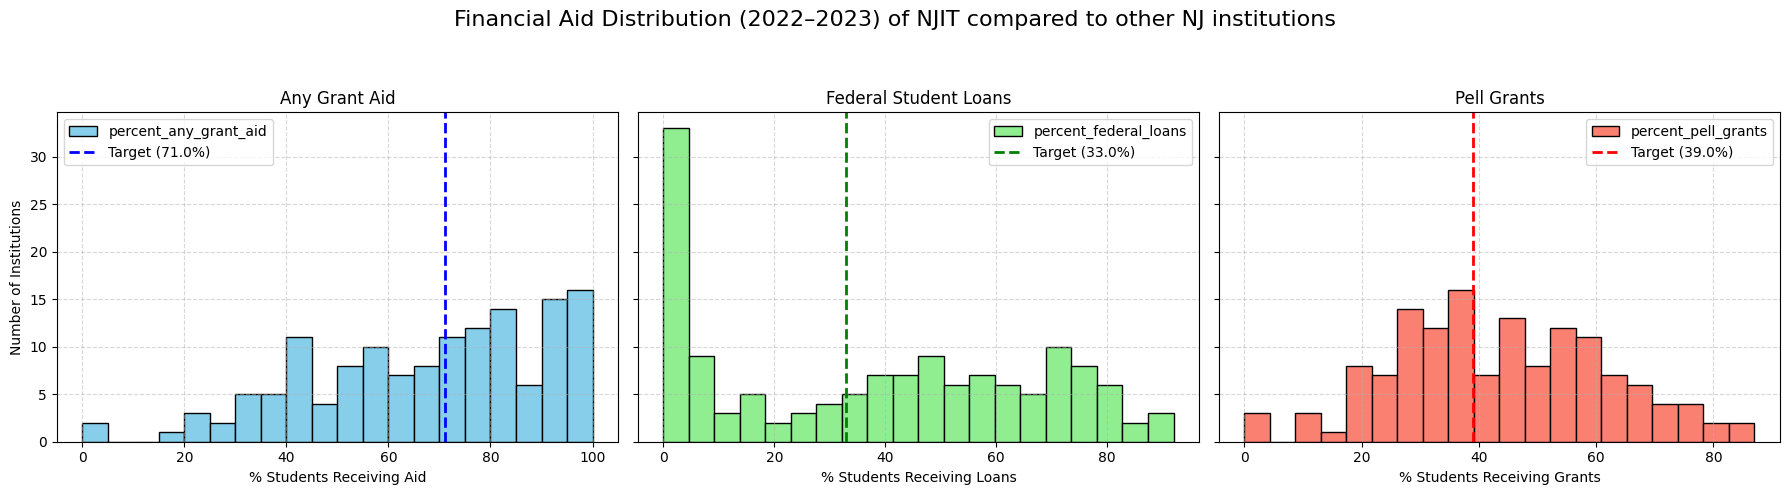

In [50]:
# Set your target unitid
target_unitid = 185828  # NJIT

# Extract values for that institution
target_row = df_selected[df_selected["unit_id"] == target_unitid]
if target_row.empty:
    print(f"UNITID {target_unitid} not found in dataset.")
else:
    val_grant = target_row["percent_any_grant_aid"].values[0]
    val_loan = target_row["percent_federal_loans"].values[0]
    val_pell = target_row["percent_pell_grants"].values[0]

    # Set up multi-panel plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    fig.suptitle('Financial Aid Distribution (2022–2023) of NJIT compared to other NJ institutions', fontsize=16)

    # Any Grant Aid
    df_selected['percent_any_grant_aid'].plot.hist(ax=axes[0], bins=20, color='skyblue', edgecolor='black')
    axes[0].axvline(val_grant, color='blue', linestyle='--', linewidth=2, label=f'Target ({val_grant:.1f}%)')
    axes[0].set_title('Any Grant Aid')
    axes[0].set_xlabel('% Students Receiving Aid')
    axes[0].legend()

    # Federal Student Loans
    df_selected['percent_federal_loans'].plot.hist(ax=axes[1], bins=20, color='lightgreen', edgecolor='black')
    axes[1].axvline(val_loan, color='green', linestyle='--', linewidth=2, label=f'Target ({val_loan:.1f}%)')
    axes[1].set_title('Federal Student Loans')
    axes[1].set_xlabel('% Students Receiving Loans')
    axes[1].legend()

    # Pell Grants
    df_selected['percent_pell_grants'].plot.hist(ax=axes[2], bins=20, color='salmon', edgecolor='black')
    axes[2].axvline(val_pell, color='red', linestyle='--', linewidth=2, label=f'Target ({val_pell:.1f}%)')
    axes[2].set_title('Pell Grants')
    axes[2].set_xlabel('% Students Receiving Grants')
    axes[2].legend()

    # Set common y-label
    for ax in axes:
        ax.set_ylabel('Number of Institutions')
        ax.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()



Variable: percent_any_grant_aid (UAGRNTP)
Full Name:
Percent of undergraduate students awarded federal, state, local, institutional, or other sources of grant aid

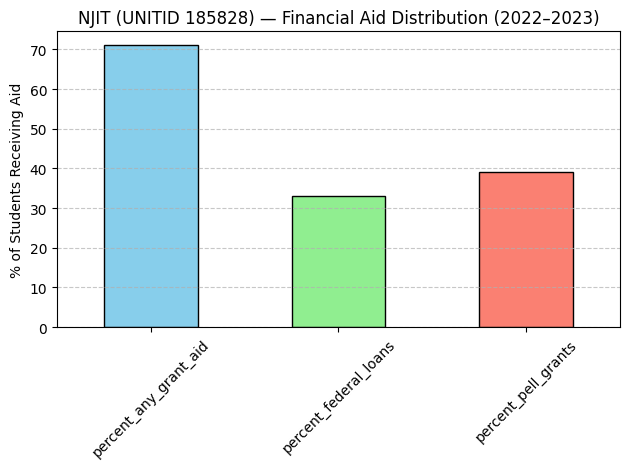

In [32]:
# Choose the institution by UNITID
target_unitid = 185828  # NJIT

# Extract row for NJIT
njit_data = df_selected[df_selected["unit_id"] == target_unitid]
if njit_data.empty:
    print("NJIT data not found.")
else:
    # Get the percentage values
    aid_values = njit_data[['percent_any_grant_aid', 'percent_federal_loans', 'percent_pell_grants']].iloc[0]

    # Plot as bar chart
    aid_values.plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon'], edgecolor='black')
    plt.title("NJIT (UNITID 185828) — Financial Aid Distribution (2022–2023)")
    plt.ylabel('% of Students Receiving Aid')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

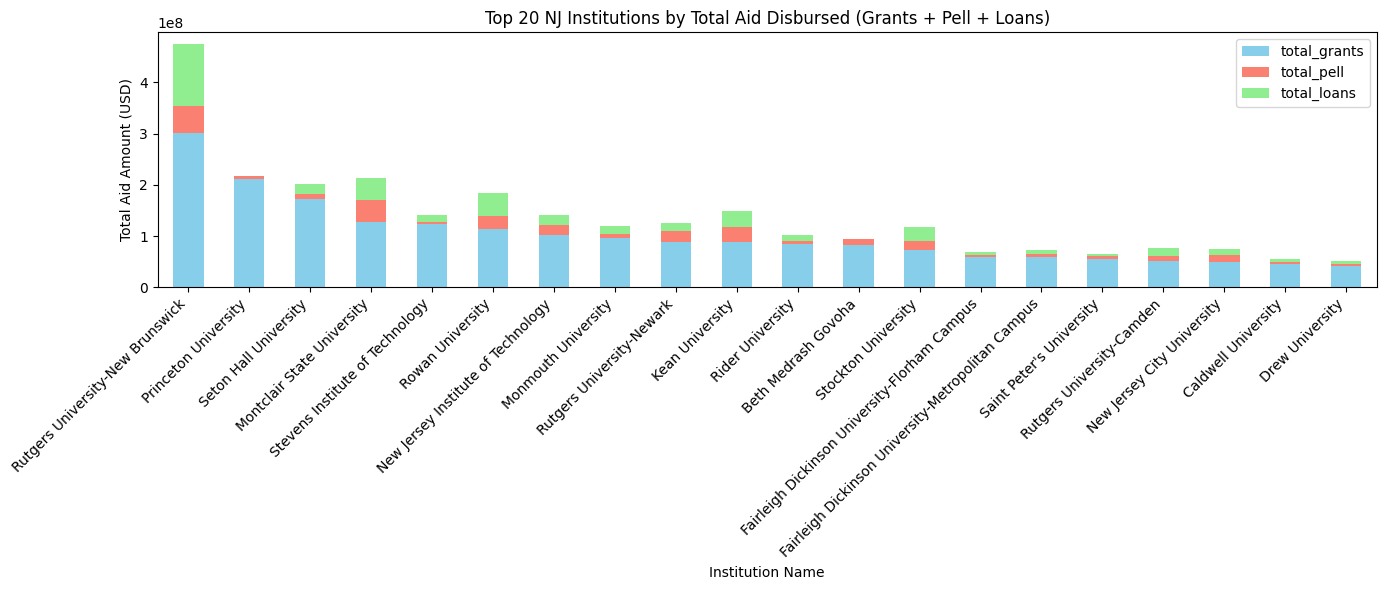

In [45]:
# Sort and take top 20 by total_grants
df_top = df_selected.sort_values(by='total_grants', ascending=False).head(20).copy()

# Add school names
df_top['school_name'] = df_top['unit_id'].apply(get_school_name)

# Plot
ax = df_top.plot(
    x='school_name',
    y=['total_grants', 'total_pell', 'total_loans'],
    kind='bar',
    stacked=True,
    figsize=(14, 6),
    color=['skyblue', 'salmon', 'lightgreen']
)

# Customize plot
plt.title("Top 20 NJ Institutions by Total Aid Disbursed (Grants + Pell + Loans)")
plt.ylabel("Total Aid Amount (USD)")
plt.xlabel("Institution Name")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [37]:
df_top.head()

,unit_id,total_grants,total_pell,total_loans
418,123961,637285590,24282555,32179523
70,104151,627107650,105571182,123031952
1994,193900,543877540,31159838,40980071
1292,164988,452274826,18075985,23893510
1900,190415,445052683,15736358,18450144
